# Introduction to the Notebook
This notebook provides an in-depth analysis of heritability estimates, focusing on the comparison between twin-based and SNP-based methods. We will preprocess the data, compute heritability estimates, perform statistical tests, and visualize the results using Nature Genetics-style plots.

# Import Required Libraries
We begin by importing the necessary libraries for data manipulation, statistical analysis, and visualization.

In [1]:
# Import Required Libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define Constants and Load Data
In this section, we define constants for the analysis and load the required datasets, including REML results and twin data.

In [2]:
# Define constants for heritability calculations
het_gr_exp = 0.4066165320272421
hom_gr_exp = 0.3433085587530389
hethom_gr_exp = 0.08333073480046829

# Load REML results
df_snp = pd.read_csv(
    "../../data/meta.tsv",
    sep="\t",
)

# Load Twin data
df_twin = pd.read_csv(
    "../../data/Twin.csv"
)

df_twin = (df_twin[["Description", "h2"]]
           .rename(columns={"Description": "pheno", "h2": "H2(TWIN)"})
           .copy()
           .dropna())

# Data Preprocessing
We clean and preprocess the loaded data, including handling missing values and summarizing statistics for twin heritability data.

In [3]:
# Summarize twin data with mean and standard error
def summarize_mean_se(df: pd.DataFrame,
                      group_col: str = "pheno",
                      value_col: str = "H2(TWIN)") -> pd.DataFrame:
    """
    Summarize mean and standard error (SE) for each phenotype.

    Parameters
    ----------
    df : pandas.DataFrame
        Original dataframe.
    group_col : str, default "pheno"
        Column to group by.
    value_col : str, default "H2(TWIN)"
        Column to calculate mean and SE.

    Returns
    -------
    pandas.DataFrame
        Dataframe with mean and SE for each group.
    """
    summary = (
        df.groupby(group_col)[value_col]
          .agg(['mean', 'count', 'std'])
          .rename(columns={'count': 'n', 'std': 'sd'})
    )
    summary['se'] = summary['sd'] / np.sqrt(summary['n'])
    summary['se'] = summary['se'].fillna(0)
    return summary[['mean', 'se']].rename(columns={"mean": "H2(TWIN)", "se": "H2(TWIN)_se"}).reset_index()

df_twin = summarize_mean_se(df_twin)
df_twin

,pheno,H2(TWIN),H2(TWIN)_se
0,Albumin,0.545000,0.185000
1,Alkaline_phosphatase,0.733333,0.090247
2,Apolipoprotein_A,0.595000,0.035707
3,Apolipoprotein_B,0.555000,0.105079
4,Body_fat_percentage,0.640000,0.079896
5,Body_mass_index__BMI_,0.716250,0.052574
6,C-reactive_protein,0.610000,0.000000
7,Cholesterol,0.476000,0.057149
8,Creatinine,0.560000,0.032404
9,Creatinine__enzymatic__in_urine,0.605000,0.025000


# Compute Heritability Estimates
We define and apply functions to compute heritability estimates (H2) from different methods, including AD and FACTOR.

In [4]:
def compute_H2(df_snp, het_corr, hom_corr, hethom_corr):
    """
    Compute heritability estimates (H2) from SNP data.

    Parameters
    ----------
    df_snp : pandas.DataFrame
        SNP data with heritability components.
    het_corr, hom_corr, hethom_corr : float
        Correction factors for heterozygous, homozygous, and hetero-homo covariance.

    Returns
    -------
    pandas.DataFrame
        Dataframe with computed H2 values.
    """
    tmp = df_snp.copy()
    
    # FACTOR
    tmp["r_MZ"] = tmp["h2(FACTOR)"]
    tmp["r_DZ"] = het_corr * tmp["h2(het)"]\
                + hom_corr * tmp["h2(hom)"]\
                + 2 * hethom_corr * tmp["Cov(hh)"] * np.sqrt(tmp["h2(het)"] * tmp["h2(hom)"])
    tmp["H2_from_FACTOR"] = 2 * (tmp["r_MZ"] - tmp["r_DZ"])
    
    # AD
    tmp["H2_from_AD"] = tmp["h2(add)"]
    
    # SE calculations
    tmp["r_MZ_se"] = tmp["h2(FACTOR)_se"]
    tmp["r_DZ_se"] = np.sqrt(
        (het_corr * tmp["h2(het)_se"])**2 + 
        (hom_corr * tmp["h2(hom)_se"])**2 + 
        (2 * hethom_corr * tmp["Cov(hh)_se"] * np.sqrt(tmp["h2(het)"] * tmp["h2(hom)"]))**2
    )
    tmp["H2_from_FACTOR_se"] = 2 * np.sqrt(tmp["r_MZ_se"]**2 + tmp["r_DZ_se"]**2)
    tmp["H2_from_AD_se"] = np.sqrt(tmp["h2(add)_se"]**2 + (1.5 * tmp["h2(dom)_se"])**2)
    
    # Filter negative values
    neg_ad = tmp["H2_from_AD"] < 0
    neg_factor = tmp["H2_from_FACTOR"] < 0
    tmp_filtered = tmp[~neg_ad & ~neg_factor]
    return tmp_filtered[["pheno", "H2_from_AD", "H2_from_AD_se", "H2_from_FACTOR", "H2_from_FACTOR_se"]]

df_snp_using_exp = compute_H2(df_snp, het_gr_exp, hom_gr_exp, hethom_gr_exp)
df_snp_using_exp

,pheno,H2_from_AD,H2_from_AD_se,H2_from_FACTOR,H2_from_FACTOR_se
0,Leg_predicted_mass__left_,0.223203,0.021565,0.332617,0.039206
1,Leg_fat-free_mass__right_,0.234000,0.021527,0.364163,0.036498
2,Whole_body_fat-free_mass,0.249541,0.021341,0.385389,0.036736
3,Mean_corpuscular_volume,0.258349,0.023265,0.384732,0.037078
4,SHBG,0.157856,0.024925,0.249006,0.048428
...,...,...,...,...,...
95,Whole_body_fat_mass,0.216574,0.019321,0.279208,0.041677
96,Platelet_count,0.252102,0.021731,0.356844,0.039452
97,Monocyte_count,0.218046,0.022607,0.288864,0.039547
98,Impedance_of_leg__right_,0.228167,0.021118,0.351575,0.037461


# Merge and Transform Data
We merge the processed datasets and compute additional columns such as heritability ratios and log-transformed values.

In [5]:
# Merge SNP and twin data
df_mrg_exp = pd.merge(
    df_snp_using_exp,
    df_twin,
    on="pheno",
)

# Compute heritability ratios and log-transformed values
df_mrg_exp["TWIN/AD"] = (df_mrg_exp["H2(TWIN)"] / df_mrg_exp["H2_from_AD"])
df_mrg_exp["TWIN/FACTOR"] = (df_mrg_exp["H2(TWIN)"] / df_mrg_exp["H2_from_FACTOR"])
df_mrg_exp["log2_TWIN/AD"] = np.log2(df_mrg_exp["TWIN/AD"]) 
df_mrg_exp["log2_TWIN/FACTOR"] = np.log2(df_mrg_exp["TWIN/FACTOR"])

df_mrg_exp[["TWIN/AD", "TWIN/FACTOR"]].agg(["median", "mean", "std"]).round(3)

,TWIN/AD,TWIN/FACTOR
median,3.334,2.137
mean,4.439,2.607
std,4.462,1.624


# Statistical Tests
We perform statistical tests (Mann-Whitney U-test and Wilcoxon signed-rank test) to compare heritability estimates.

In [6]:
# Define variables for comparison
a = "log2_TWIN/AD"
b = "log2_TWIN/FACTOR"

# Remove missing values and extract data
df = df_mrg_exp[[a, b]].dropna()
x = df[a].to_numpy()
y = df[b].to_numpy()

# Perform statistical tests
u_res = stats.mannwhitneyu(x, y, alternative="two-sided", method="auto")
w_res = stats.wilcoxon(x, y, alternative="two-sided", zero_method="wilcox", correction=False)

print(f"Mann-Whitney U-test: U={u_res.statistic:.3f}, p-value={u_res.pvalue:.4g}")
print(f"Wilcoxon signed-rank test: W={w_res.statistic:.3f}, p-value={w_res.pvalue:.4g}")

Mann-Whitney U-test: U=2051.000, p-value=3.419e-08
Wilcoxon signed-rank test: W=0.000, p-value=1.776e-15


# Twin Heritability Comparison Plot
We generate a plot to compare twin heritability estimates with confidence intervals.

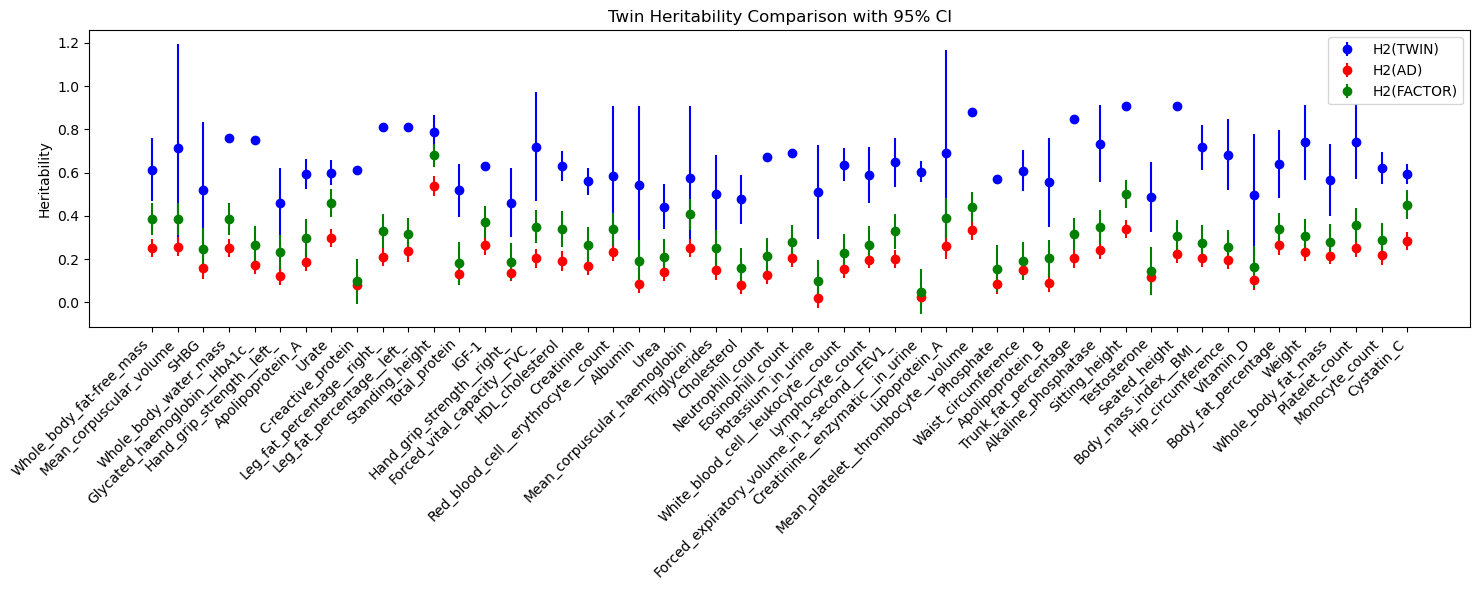

In [12]:
# Generate twin heritability comparison plot with 95% CI
def plot_twin_heritability_comparison(df_mrg_exp, figsize=(10, 6)):
    """
    Twin heritability comparison plot with 95% confidence intervals.
    """
    plt.figure(figsize=figsize)
    
    # Calculate 95% CI for each heritability estimate
    twin_ci = 1.96 * df_mrg_exp['H2(TWIN)_se']
    ad_ci = 1.96 * df_mrg_exp['H2_from_AD_se']
    factor_ci = 1.96 * df_mrg_exp['H2_from_FACTOR_se']
    
    # Plot with error bars for 95% CI
    plt.errorbar(df_mrg_exp['pheno'], df_mrg_exp['H2(TWIN)'], 
                 yerr=twin_ci, fmt='o', label='H2(TWIN)', color='blue')
    plt.errorbar(df_mrg_exp['pheno'], df_mrg_exp['H2_from_AD'], 
                 yerr=ad_ci, fmt='o', label='H2(AD)', color='red')
    plt.errorbar(df_mrg_exp['pheno'], df_mrg_exp['H2_from_FACTOR'], 
                 yerr=factor_ci, fmt='o', label='H2(FACTOR)', color='green')
    
    # Customize plot
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Heritability')
    plt.title('Twin Heritability Comparison with 95% CI')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_twin_heritability_comparison(df_mrg_exp, figsize=(15, 6))

# Heritability Ratio Comparison Plot
We create a plot to compare heritability ratios (log2(TWIN/AD) and log2(TWIN/FACTOR)) with mean lines.

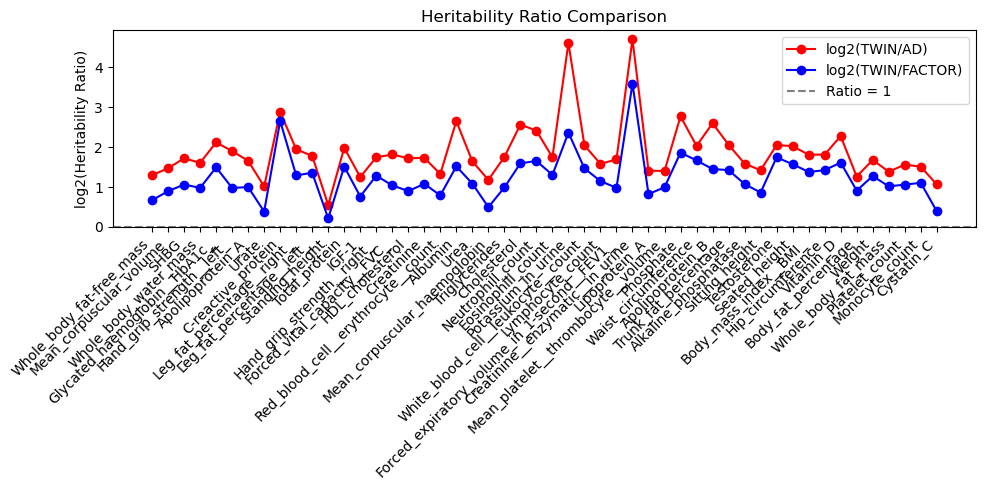

In [13]:
# Generate heritability ratio comparison plot
def plot_heritability_ratio_comparison(df_mrg_exp, figsize=(10, 6)):
    """
    Simplified heritability ratio comparison plot.
    """
    plt.figure(figsize=figsize)
    x = np.arange(len(df_mrg_exp))
    plt.plot(x, df_mrg_exp['log2_TWIN/AD'], 'o-', label='log2(TWIN/AD)', color='red')
    plt.plot(x, df_mrg_exp['log2_TWIN/FACTOR'], 'o-', label='log2(TWIN/FACTOR)', color='blue')
    plt.axhline(0, color='gray', linestyle='--', label='Ratio = 1')
    plt.xticks(x, df_mrg_exp['pheno'], rotation=45, ha='right')
    plt.ylabel('log2(Heritability Ratio)')
    plt.title('Heritability Ratio Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_heritability_ratio_comparison(df_mrg_exp, figsize=(10, 5))